
# Face detection

Database scraped from WhichFaceIsReal. Can You guess which face is real?

Face 1              |Face 2
:-------------------------:|:-------------------------:
![alt text](imgs/fakeex.jpeg) |  ![alt text](imgs/realex.jpeg)


## Different Datasets?
We looked at different datasets but ultimately decided on scraping https://www.whichfaceisreal.com since it provided clean and centered images without watermarks for our use case.
Other datasets either included images with a very bad resolution or only pictures of celebrities.
Since we did not want to include a bias of only professionally taken pictures of celebrities, we decided not to take it.


## Configuring the Dataset

Before running this code you need to prepare the image database:
```
Datasets/trainset/
    fakeimages/
        image1.jpg
        image2.jpg
        ...
    realimages/
        image1.jpg
        image2.jpg
        ...
Datasets/testset/
    fakeimages/
        image1.jpg
        image2.jpg
        ...
    realimages/
        image1.jpg
        image2.jpg
        ...
```

In [2]:
#! pip install torch
import torch
import numpy
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils

from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
torch.manual_seed(161)

define image transform pipeline for image normalization

In [3]:
train_transform = transforms.Compose([    
    transforms.Resize((224, 224)),    
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

### More augmentations?

![](imgs/augmentations.png)
![](imgs/augmentations_photo.png)
*did not really help*

As seen above, we also tried more (extreme) augmentations of the training data. These augmentations however did not improve our model.

## Dataloaders
Load images from paths and create usable dataloaders

In [4]:
learn_images_path = 'Datasets/trainset'
test_images_path = 'Datasets/testset/'

#Load images into datasets
trainset = datasets.ImageFolder(root=learn_images_path, transform=train_transform)
testset = datasets.ImageFolder(root=test_images_path, transform=test_transform)

batch_size = 32

#dataloader
train_loader = DataLoader(trainset, batch_size, shuffle=True, drop_last = True)
test_loader = DataLoader(testset, batch_size, shuffle=True, drop_last = True)

### Test dataloaders
Test dataloaders and show loaded images

In [5]:
print(trainset)
len(trainset)
print(testset)
len(test_loader)

Dataset ImageFolder
    Number of datapoints: 900
    Root location: Datasets/trainset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=1)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 100
    Root location: Datasets/testset/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


3

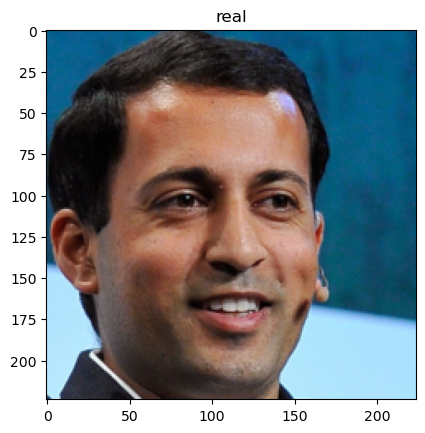

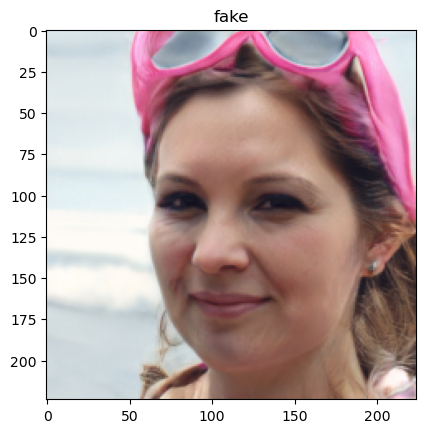

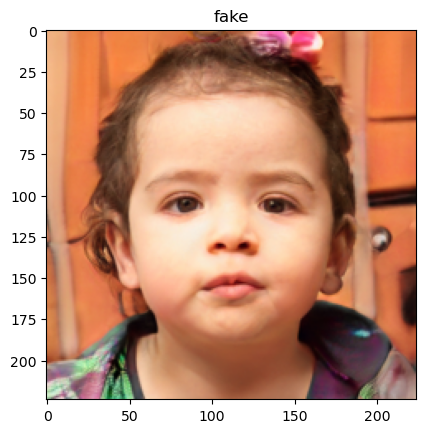

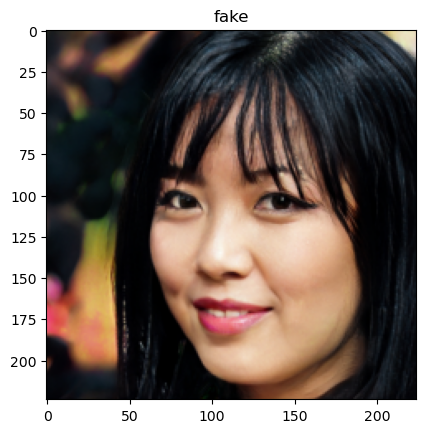

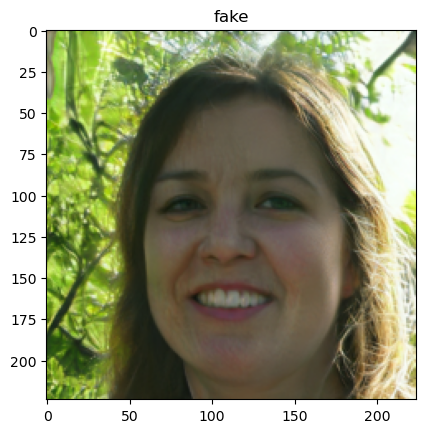

In [24]:
images, labels  = next(iter(train_loader))

classes = ['fake', 'real']

def imshow(img, title):
    plt.imshow(numpy.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

# get and show random training images
num_images_to_show = 5

for i in range(num_images_to_show):
    rand_idx = numpy.random.randint(len(images))
    img, label = images[rand_idx], labels[rand_idx]
    class_name = classes[label.item()]
    
    imshow(img, title=class_name)

In [7]:
images.shape

torch.Size([32, 3, 224, 224])

## Model definition


### VGG-16 CNN Model (Convolutional Neural Network) 
### Why VGG-16?
- After some research and comparing different models like CIFAR10 we came to the conclusion to take the VGG-16 pretrained model
- It is simple yet effective and versatile
- Listed by Torch as the best neuronal network for image classification
- Classifies 1000 Pictures in 1000 different classes with an accuracy of 92.7%.
- The "Schweizer Taschenmesser" of image classification
- 
![](imgs/vgg16Architecture.png)
*https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918* 

#### Pretrained model
- Pretrained because our notebooks don't have the best performance and transfer learning works well
- Weights of the feature extractor are frozen
- We modify the classifier
![](imgs/dnnExtractorClassifier.png)
*https://griesshaber.pages.mi.hdm-stuttgart.de/nlp/07neuralnetworks/03ConvolutionNeuralNetworks.html*

### Testing different settings
- We tried out an Adaptive-Average-Pooling-Layer-Size of 2,2 (and the corresponding Linear-Layer size) which led to underfitting after we trained our model. We interpreted it as not having enough neurons which causes underfitting. After that we tried out different Pooling-Sizes and found 7,7 to bring us the best results.
- Initially we took 0.001 as our learning rate. Later on while evaluating the model, the graph of our learning progress was alternating. That means that the model overshot the optimale minimum value. Changing the learning rate to a smaller one 0.0001 fixed this problem.

In [8]:
vgg16 = models.vgg16(pretrained=True)

#deactivate training for pretrained layers
for param in vgg16.features.parameters():
    param.requires_grad = False #freeze weights

#Parameter Block
vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))  

vgg16.classifier = nn.Sequential(  
        nn.Linear(512 * 7 * 7, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),  # one outpout neuron : binary classifier fake or real
        nn.Sigmoid())
loss_fn = nn.BCELoss()

# define loss function and optimizer BCE=BinaryCrossEntropy
criterion = nn.BCELoss() #cross entropy is better for binary classifiers
#stochastik gradient descent
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.5,) #momentum for faster learning at first and then it refines the learning

C:\Users\jakob\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jakob\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model Training preperations
Set Device to MPS (MacBook) or Cuda for faster Learning on GPU and print model summary

In [9]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

vgg16 = vgg16.to(device)

#summary(vgg16, [(3, 224, 224)])
#print("")

Device: cuda


In [10]:
## utility function to compute accuracy
def get_accuracy(output, target, batch_size):
    predictions = torch.round(output)
    corrects = (predictions == target).sum().item()
    accuracy = 100.0 * corrects / batch_size
    return accuracy

## Training Magic

Training for 50 Epochs. Too many epochs cause overfitting, too little cause underfitting since it is not trained enough.
Monitor training with training and test accuracy.

In [11]:
num_epochs = 50
train_acc_list=[]
test_acc_list=[]

for epoch in range(num_epochs):
    vgg16.train()

    #Train and test Params
    train_running_loss = 0.0
    train_acc = 0.0
    test_running_loss = 0.0
    test_acc = 0.0

    for i, (images, labels) in enumerate(train_loader):
        #move tensors to GPU
        inputs, labels = images.to(device), labels.to(device)
        labels = labels.squeeze()

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        outputs = outputs.squeeze(dim=1)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        #Set Accuracy and running loss
        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, batch_size)

    #print(i,train_acc)
    acc_train=train_acc/(i+1)
    loss_train=train_running_loss / (i+1)
    train_acc_list.append(acc_train)

    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        vgg16.eval()
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1)

        ## forward + backprop + loss
        predictions = vgg16(images)
    
        loss = criterion(predictions, labels.float())

        test_running_loss += loss.detach().item()
        test_acc += get_accuracy(predictions, labels, batch_size)
    
    #print(i,train_acc)
    acc_test=test_acc/(i+1)
    loss_test=test_running_loss / (i+1)
    test_acc_list.append(acc_test)
    
    print('Epoch: %d | Train Loss: %.4f | Train Accuracy: %.2f | Val. Loss: %.4f | Val. Accuracy: %.2f' \
          %(epoch,loss_train,acc_train,loss_test,acc_test)) 

Epoch: 0 | Train Loss: 0.6939 | Train Accuracy: 50.78 | Val. Loss: 0.6782 | Val. Accuracy: 60.42
Epoch: 1 | Train Loss: 0.6832 | Train Accuracy: 56.03 | Val. Loss: 0.6699 | Val. Accuracy: 60.42
Epoch: 2 | Train Loss: 0.6790 | Train Accuracy: 58.48 | Val. Loss: 0.6629 | Val. Accuracy: 65.62
Epoch: 3 | Train Loss: 0.6699 | Train Accuracy: 60.04 | Val. Loss: 0.6568 | Val. Accuracy: 68.75
Epoch: 4 | Train Loss: 0.6623 | Train Accuracy: 63.39 | Val. Loss: 0.6505 | Val. Accuracy: 70.83
Epoch: 5 | Train Loss: 0.6532 | Train Accuracy: 65.51 | Val. Loss: 0.6442 | Val. Accuracy: 71.88
Epoch: 6 | Train Loss: 0.6459 | Train Accuracy: 65.07 | Val. Loss: 0.6374 | Val. Accuracy: 68.75
Epoch: 7 | Train Loss: 0.6392 | Train Accuracy: 68.08 | Val. Loss: 0.6322 | Val. Accuracy: 71.88
Epoch: 8 | Train Loss: 0.6340 | Train Accuracy: 67.19 | Val. Loss: 0.6255 | Val. Accuracy: 71.88
Epoch: 9 | Train Loss: 0.6268 | Train Accuracy: 68.30 | Val. Loss: 0.6198 | Val. Accuracy: 72.92
Epoch: 10 | Train Loss: 0.6253

### Training conclusion
- Accuracy of ~75% is not good but it is something
- Fewer neurons could prevent overfitting
- Accuracy could be improved by fine tuning the model which works by unfreezing (some of) the layers of the feature extractor. The learning process would then also tune these weights. Sadly we could not apply fine tuning due to limited resources and time constraints.

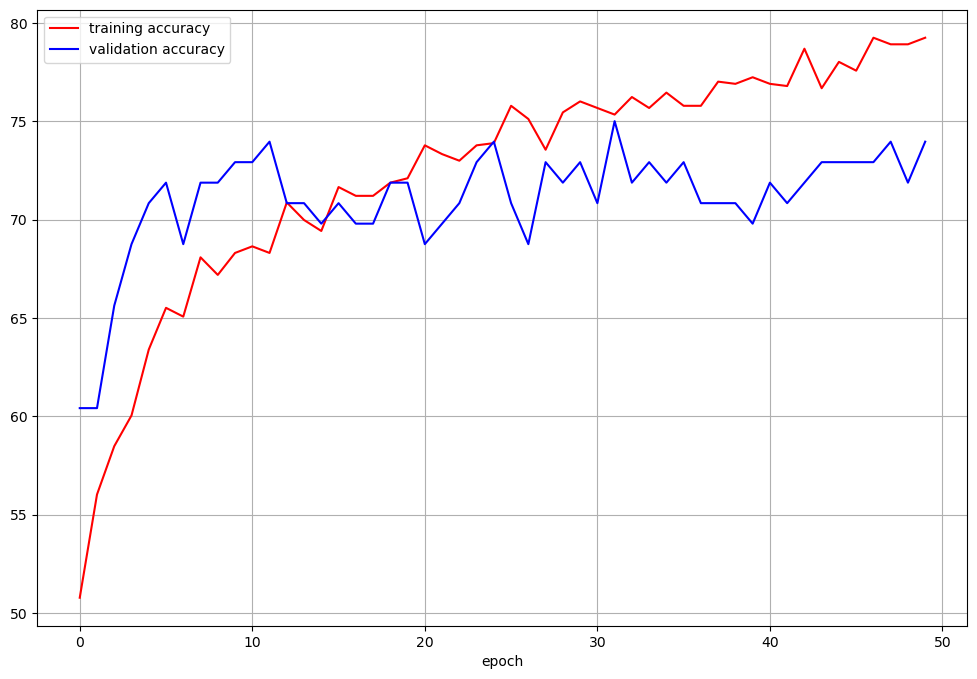

In [12]:
plt.figure(figsize=(12,8))
plt.plot(range(num_epochs),train_acc_list,"r",label="training accuracy")
plt.plot(range(num_epochs),test_acc_list,"b",label="validation accuracy")
plt.xlabel("epoch")
plt.grid(True)
plt.legend()
plt.show()

### Save trained model
Saving whole model instead of only the dictionary. Saving only the dictionary is also possible but lead to problems when loading the model down the line

In [13]:
model_save_path = 'model/vgg16_model.pth'

#save model
torch.save(vgg16, model_save_path)

### Load model

In [14]:
import torch
import torchvision.models as models

# Define the VGG16 model

# Load the saved model checkpoint
checkpoint_path = 'model/vgg16_model.pth'  # Replace with the actual path to your saved checkpoint file

# Load the state dictionary into the model
vgg16 = torch.load(checkpoint_path)

# Optional: Load other items from the checkpoint, such as optimizer state, epoch number, etc.
# optimizer.load_state_dict(checkpoint['optimizer'])
# epoch = checkpoint['epoch']

# Set the model to evaluation mode
vgg16.eval()

# Now, vgg16 is loaded with the saved weights and ready for use



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Test Pictures
Rate example pictures and classify them by certainty

Device: cuda


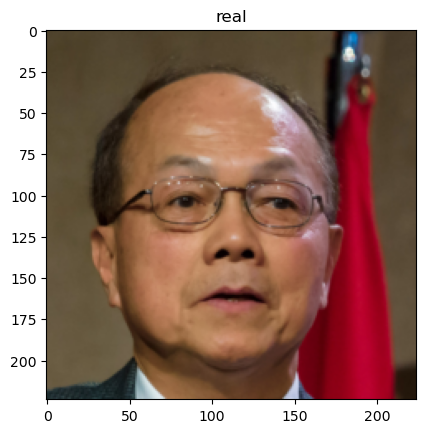

Predicted Class: real
certainty: 0.6630935072898865


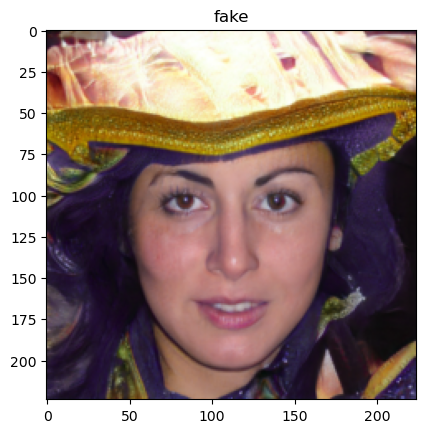

Predicted Class: real
certainty: 0.6861656904220581


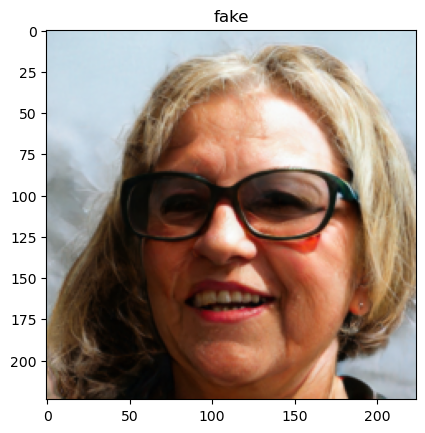

Predicted Class: real
certainty: 0.6770855188369751


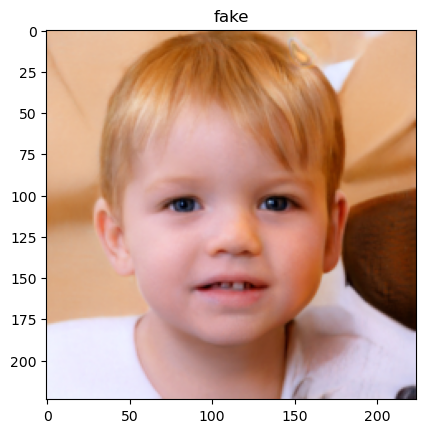

Predicted Class: fake
certainty: 0.6493138372898102


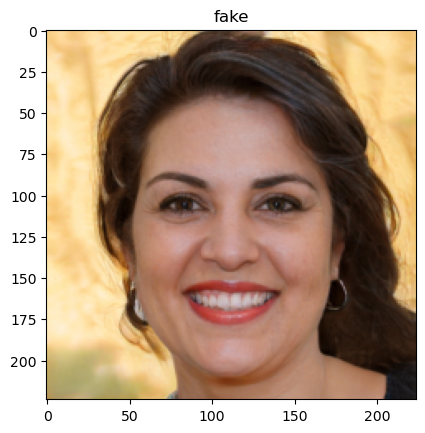

Predicted Class: fake
certainty: 0.79216568171978


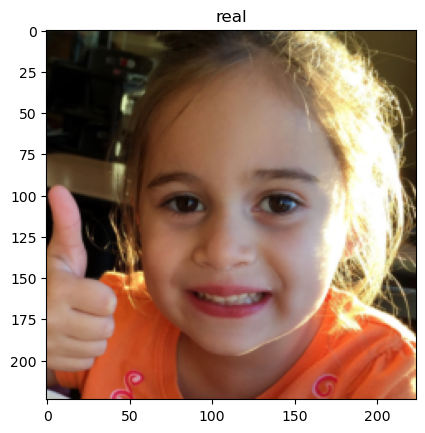

Predicted Class: fake
certainty: 0.577038049697876


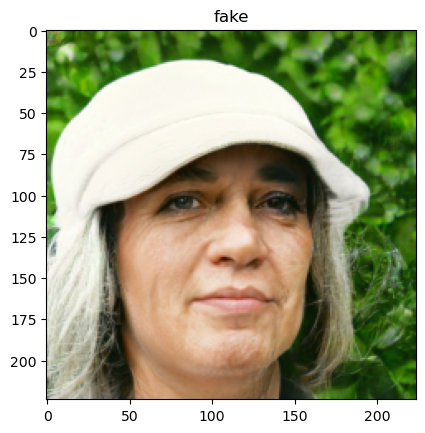

Predicted Class: real
certainty: 0.5718788504600525


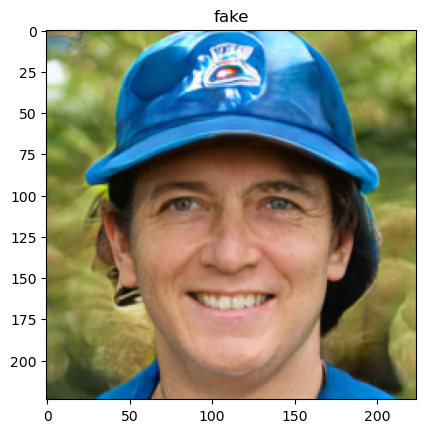

Predicted Class: fake
certainty: 0.7488059401512146


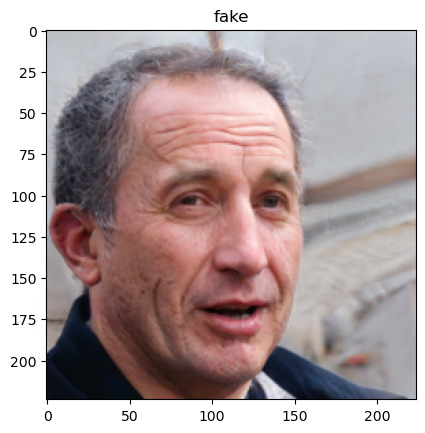

Predicted Class: fake
certainty: 0.5725702047348022


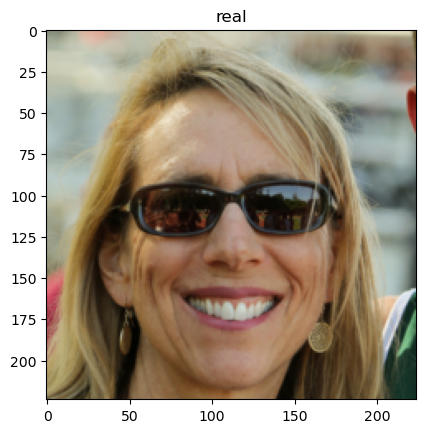

Predicted Class: real
certainty: 0.6519384384155273


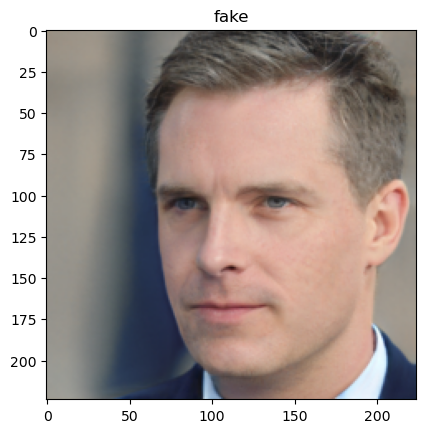

Predicted Class: fake
certainty: 0.6181545555591583


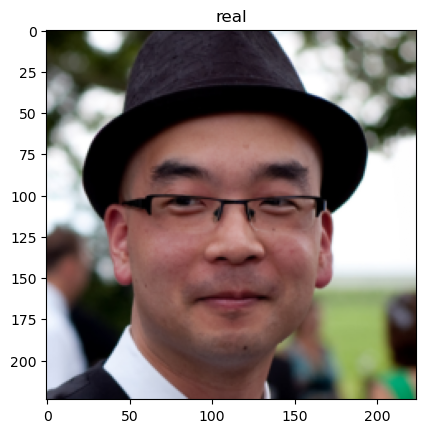

Predicted Class: fake
certainty: 0.5049266517162323


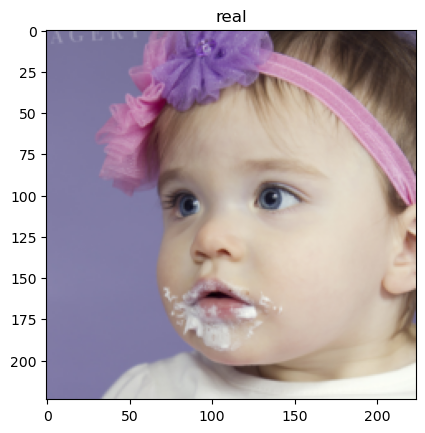

Predicted Class: real
certainty: 0.894139289855957


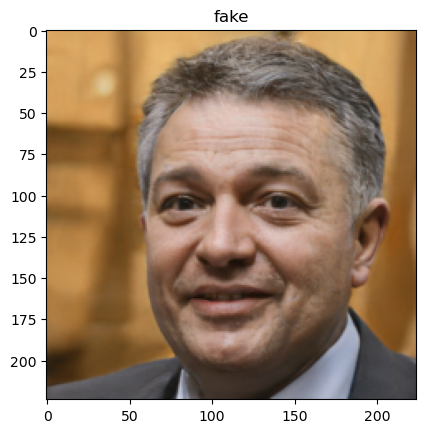

Predicted Class: real
certainty: 0.5058432221412659


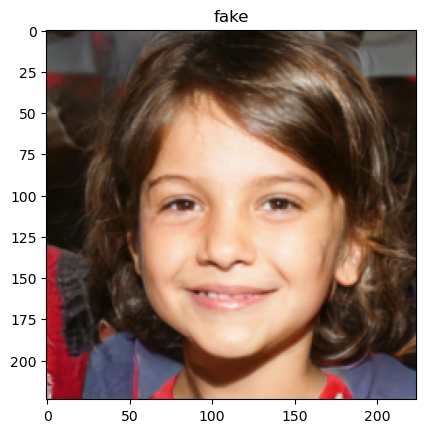

Predicted Class: fake
certainty: 0.7605040818452835


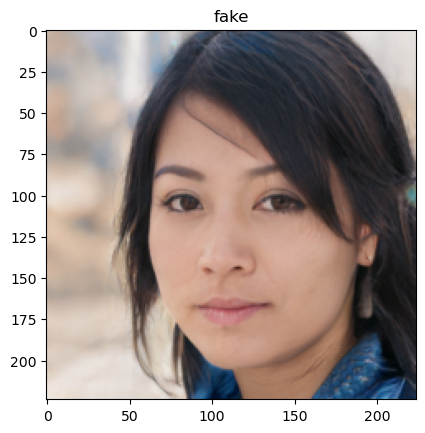

Predicted Class: real
certainty: 0.7068403959274292


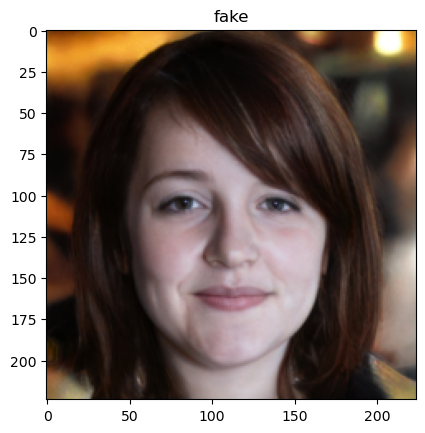

Predicted Class: fake
certainty: 0.6000813841819763


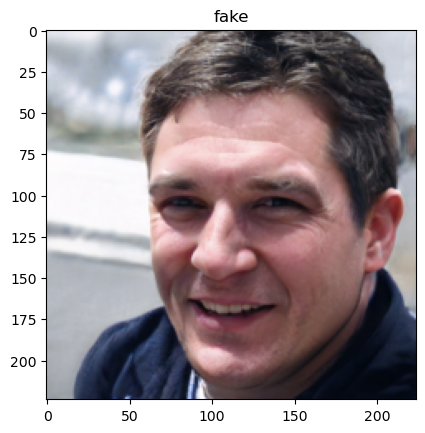

Predicted Class: fake
certainty: 0.5514966249465942


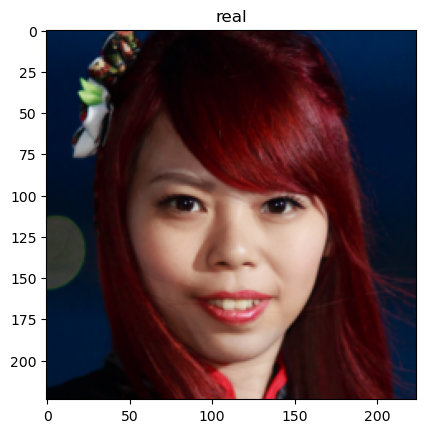

Predicted Class: real
certainty: 0.5569964051246643


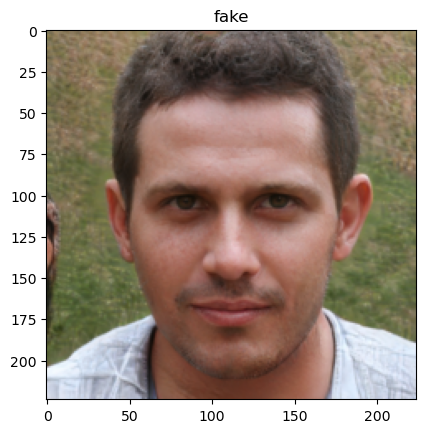

Predicted Class: fake
certainty: 0.7035695016384125


In [26]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

vgg16 = vgg16.to(device)

images, labels = next(iter(test_loader))
#imshow(images[0], classes[labels[0].item()]) 

inputs, labels = images.to(device), labels.to(device)
vgg16.eval()


for i in range(20):

    index_to_classify = i
    image_to_classify = inputs[index_to_classify].unsqueeze(0).to(device)
    label_to_classify = labels[index_to_classify].item()
    imshow(images[i], classes[labels[i].item()])

    with torch.no_grad():
        output = vgg16(image_to_classify)

    def classify_output(probabilities, threshold=0.5):
    # Check if the probability is greater than or equal to the threshold
        if probabilities >= threshold:
            return probabilities
        else:
            return abs(probabilities-0.5)+0.5

    predicted_class = output.tolist().__getitem__(0)[0]
    certainty = classify_output(predicted_class)
    print("Predicted Class:", classes[round(predicted_class)])
    print("certainty:", certainty)

As seen above, our trained model classifies the pictures with a round about 68% certaincy